# NN for Text Classification

## Modules and Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#pip install tensorflow_text

In [ ]:
#pip install umap-learn

In [ ]:
#pip install hdbscan

In [ ]:
#pip install sentence_transformers

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning, message=".*PerformanceWarning.*")


from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#from sentence_transformers import SentenceTransformer
#import umap
#import hdbscan

In [ ]:
disagreements = pd.read_csv('/content/drive/MyDrive/Text Classification/Disagreements_Processed_Complete.csv').drop('Unnamed: 0', axis = 1)
disagreements.head()

,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement,Words
0,1,No. 02-9007.,https://www.leagle.com/decision/2004458362f3d9...,1,0,"united,state,court,appeal,first,circuit,cyr,se..."
1,1,No. 03-1307.,https://www.leagle.com/decision/2004416377f3d3...,0,1,"united,state,court,appeal,first,circuit,boudin..."
2,1,No. 03-1453.,https://www.leagle.com/decision/2004585370f3d2...,1,1,"united,state,court,appeal,first,circuit,torrue..."
3,1,No. 03-1678.,https://www.leagle.com/decision/2004383361f3d2...,1,0,"united,state,court,appeal,first,circuit,stahl,..."
4,1,No. 03-1795.,https://www.leagle.com/decision/2007542480f3d6...,0,1,"united,state,court,appeal,first,circuit,lynch,..."


In [ ]:
def error_decomposition(x, y, n = 7, model = ensemble.RandomForestClassifier()):
    n = 7
    sample = len(x)//n

    accuracies = []
    false_positives = []
    false_negatives = []
    all_preds = np.zeros(shape = len(y))
    all_indexes = np.arange(len(x))

    for i in range(n):
        test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
        train_indexes = [j for j in range(len(y)) if j not in test_indexes]
        train_x = x[train_indexes]
        test_x = x[test_indexes]

        train_y = y[train_indexes]
        test_y = y[test_indexes]

        model.fit(train_x, train_y)
        preds = model.predict(test_x)
        all_preds[len(test_x)*i:len(test_x)*(i+1)] = preds

        correct = 0
        false_positive = 0
        false_negative = 0

        for k in range(len(preds)):
            if test_y[k] == preds[k]:
                correct += 1
            elif test_y[k] == 0 and preds[k] == 1:
                false_positive += 1
            elif test_y[k] == 1 and preds[k] == 0:
                false_negative += 1

        all_indexes = list(all_indexes)
        for index in test_indexes:
            all_indexes.remove(index)
        all_indexes = np.array(all_indexes)

        accuracies.append(correct*100/sample)
        false_positives.append(false_positive*100/sample)
        false_negatives.append(false_negative*100/sample)

    return np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives), all_preds

In [ ]:
def error_decomposition_2(x, y, n = 7, model = ensemble.RandomForestClassifier()):

    n = 7
    sample = len(x)//n

    positive_positive = 0
    positive_negative = 0
    negative_negative = 0
    negative_positive = 0

    all_preds = np.zeros(shape = len(y))
    all_indexes = np.arange(len(x))

    for i in range(n):
        test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
        train_indexes = [j for j in range(len(y)) if j not in test_indexes]
        train_x = x[train_indexes]
        test_x = x[test_indexes]

        train_y = y[train_indexes]
        test_y = y[test_indexes]

        model.fit(train_x, train_y)
        preds = model.predict(test_x)
        all_preds[len(test_x)*i:len(test_x)*(i+1)] = preds

        for k in range(len(preds)):
            if test_y[k] == 0 and preds[k] == 0:
                negative_negative += 1
            elif test_y[k] == 1 and preds[k] == 1:
                positive_positive += 1
            elif test_y[k] == 1 and preds[k] == 0:
                positive_negative += 1
            elif test_y[k] == 0 and preds[k] == 1:
                negative_positive += 1

        all_indexes = list(all_indexes)
        for index in test_indexes:
            all_indexes.remove(index)
        all_indexes = np.array(all_indexes)

    return positive_positive*100/len(y[y == 1]), positive_negative*100/len(y[y == 1]), negative_negative*100/len(y[y == 0]), negative_positive*100/len(y[y == 0])

# Attempt 1

In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
x = disagreements['Words']
y = list(disagreements['sr_disagreement'])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)
x_train.head()

2745    julie,carnes,circuit,judge,appeal,require,deci...
2830    united,state,court,appeal,federal,circuit,scha...
1699    united,state,court,appeal,eighth,circuit,loken...
702     united,state,court,appeal,fifth,circuit,garwoo...
2480    united,state,court,appeal,ninth,circuit,callah...
Name: Words, dtype: object

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
72/72 [==============================] - 1237s 17s/step - loss: 0.6175 - accuracy: 0.7118
Epoch 2/2
72/72 [==============================] - 1209s 17s/step - loss: 0.5915 - accuracy: 0.7309


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(disagreements['Words'],disagreements['ir_disagreement'], stratify=disagreements['ir_disagreement'])

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
72/72 [==============================] - 1234s 17s/step - loss: 0.6938 - accuracy: 0.5521
Epoch 2/2
72/72 [==============================] - 1231s 17s/step - loss: 0.6871 - accuracy: 0.5729


# Attempt 2

In [ ]:
model_transf = SentenceTransformer('distilbert-base-nli-mean-tokens')
#model_transf = SentenceTransformer('all-mpnet-base-v2')
embeddings = model_transf.encode(disagreements['Words'], show_progress_bar=True)
embeddings_new = embeddings.reshape(-1, len(embeddings[0]))

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
# Embeddings with Traditional ML

ml_model = ensemble.RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
y = disagreements['ir_disagreement']
scores = cross_val_score(ml_model, embeddings, y, scoring='accuracy', cv=cv)
print(f'CV Accuracy: {np.mean(scores)}')

ml_model.fit(embeddings_new, y)
preds = np.array(ml_model.predict(embeddings_new))
train_acc = (np.array(y) == preds).sum()/len(preds)
print(f'Training Accuracy: {train_acc}')

CV Accuracy: 0.6488728608427801
Training Accuracy: 0.9964192708333334


In [ ]:
y = np.array(disagreements['ir_disagreement'])
accuracy, false_positive, false_negative, all_preds = error_decomposition(embeddings_new, y)
print(accuracy, false_positive, false_negative, all_preds.sum()/len(all_preds))

64.77495107632095 25.309849967384217 9.915198956294848 0.740234375


In [ ]:
y = np.array(disagreements['ir_disagreement'])
positive_positive, positive_negative, negative_negative, negative_positive = error_decomposition_2(embeddings_new, y)
print(positive_positive, positive_negative, negative_negative, negative_positive)

81.41592920353982 18.307522123893804 39.08227848101266 60.83860759493671


In [ ]:
y = disagreements['sr_disagreement']
scores = cross_val_score(ml_model, embeddings, y, scoring='accuracy', cv=cv)
print(f'CV Accuracy: {np.mean(scores)}')

ml_model.fit(embeddings, y)
preds = np.array(ml_model.predict(embeddings))
train_acc = (np.array(y) == preds).sum()/len(preds)
print(f'Training Accuracy: {train_acc}')

CV Accuracy: 0.7276477851726705
Training Accuracy: 0.9964192708333334


In [ ]:
y = np.array(disagreements['sr_disagreement'])
accuracy, false_positive, false_negative, all_preds = error_decomposition(embeddings_new, y)
print(accuracy, false_positive, false_negative, all_preds.sum()/len(all_preds))

72.83105022831049 25.994781474233527 1.1741682974559686 0.9778645833333334


In [ ]:
y = np.array(disagreements['sr_disagreement'])
positive_positive, positive_negative, negative_negative, negative_positive = error_decomposition_2(embeddings_new, y)
print(positive_positive, positive_negative, negative_negative, negative_positive)

97.59679572763685 2.2251891410769917 4.606060606060606 95.15151515151516


## IR vs SR Disagreement

In [ ]:
all_dis = disagreements[(disagreements['ir_disagreement'] == 1) & (disagreements['sr_disagreement'] == 1)]
null_dis = disagreements[(disagreements['ir_disagreement'] == 0) & (disagreements['sr_disagreement'] == 0)]
sub_dis = disagreements[(~disagreements.index.isin(all_dis.index)) & (~disagreements.index.isin(null_dis.index))]
print(sub_dis.shape)
sub_dis.head()

(2089, 6)


,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement,Words
0,1,No. 02-9007.,https://www.leagle.com/decision/2004458362f3d9...,1,0,"united,state,court,appeal,first,circuit,cyr,se..."
1,1,No. 03-1307.,https://www.leagle.com/decision/2004416377f3d3...,0,1,"united,state,court,appeal,first,circuit,boudin..."
3,1,No. 03-1678.,https://www.leagle.com/decision/2004383361f3d2...,1,0,"united,state,court,appeal,first,circuit,stahl,..."
4,1,No. 03-1795.,https://www.leagle.com/decision/2007542480f3d6...,0,1,"united,state,court,appeal,first,circuit,lynch,..."
6,1,No. 03-2062.,https://www.leagle.com/decision/2004424382f3d4...,0,1,"united,state,court,appeal,first,circuit,lynch,..."


In [ ]:
sub_emb = embeddings[sub_dis.index]
y = np.array(sub_dis['sr_disagreement'])
accuracy, false_positive, false_negative, all_preds = error_decomposition(sub_emb, y)
print(accuracy, false_positive, false_negative, all_preds.sum()/len(all_preds))

63.18312559923299 26.84563758389262 9.971236816874399 0.7726184777405457


## Clusters

In [ ]:
umap_embedder = umap.UMAP(n_neighbors=15,
                            n_components=2,
                            metric='cosine')
umap_embeddings = umap_embedder.fit_transform(embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=25,
                          metric='euclidean',
                          cluster_selection_method='eom')
clusters = clusterer.fit(umap_embeddings)

In [ ]:
umap_data = pd.DataFrame()
umap_data['x'] = umap_embeddings[:, 0]
umap_data['y'] = umap_embeddings[:, 1]
umap_data['Label'] = clusters.labels_
umap_data.head()

,x,y,Label
0,0.329238,3.701702,4
1,-0.478959,5.024628,6
2,-1.486725,4.465458,-1
3,0.190490,4.023723,4
4,0.906072,1.654439,4


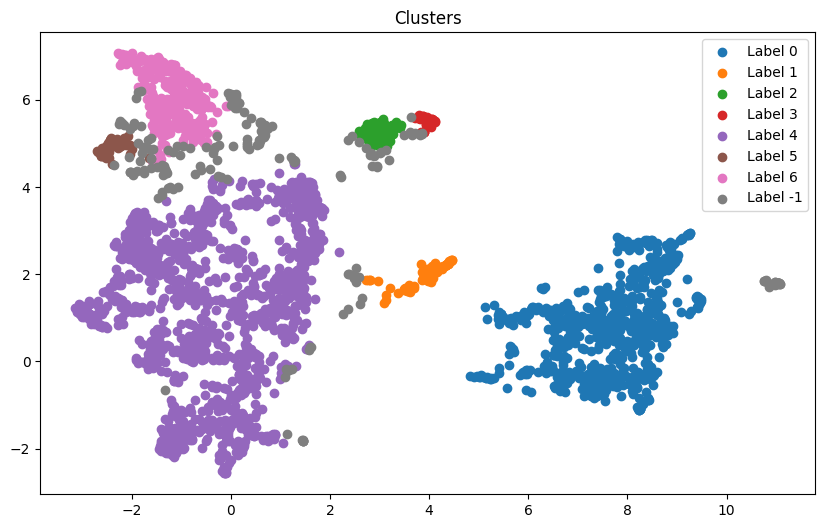

In [ ]:
plt.figure(figsize = (10,6))
for label in list(set(clusters.labels_)):
  #if label != -1:
  x = np.array(umap_data.loc[umap_data['Label'] == label, 'x'])
  y = np.array(umap_data.loc[umap_data['Label'] == label, 'y'])
  plt.scatter(x, y, label = f'Label {label}')
plt.legend()
plt.title('Clusters')
plt.show()

In [ ]:
disagreements['Label'] = clusters.labels_
for label in list(set(clusters.labels_)):
  ir_perc = disagreements[(disagreements['ir_disagreement'] == 1) & (disagreements['Label'] == label)].shape[0]*100/disagreements[disagreements['Label'] == label].shape[0]
  sr_perc = disagreements[(disagreements['sr_disagreement'] == 1) & (disagreements['Label'] == label)].shape[0]*100/disagreements[disagreements['Label'] == label].shape[0]
  print(f'IR % for label {label}: {ir_perc}')
  print(f'SR % for label {label}: {sr_perc}')
  print('')

IR % for label 0: 70.375
SR % for label 0: 70.0

IR % for label 1: 73.41772151898734
SR % for label 1: 74.68354430379746

IR % for label 2: 51.64835164835165
SR % for label 2: 82.41758241758242

IR % for label 3: 47.36842105263158
SR % for label 3: 78.94736842105263

IR % for label 4: 57.046070460704605
SR % for label 4: 71.81571815718158

IR % for label 5: 60.78431372549019
SR % for label 5: 90.19607843137256

IR % for label 6: 36.68639053254438
SR % for label 6: 81.06508875739645

IR % for label -1: 62.814070351758794
SR % for label -1: 71.85929648241206



## DNN

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_acc, color ='b', label='Training Accuracy')
    plt.plot(x, val_acc, color = 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, train_loss, color = 'b', label='Training Loss')
    plt.plot(x, val_loss, color = 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

In [ ]:
# Average number of words

disagreements['Length'] = disagreements.apply(lambda x: len(x['Words'].split(',')), axis = 1)
print(disagreements['Length'].mean())

4414.408854166667


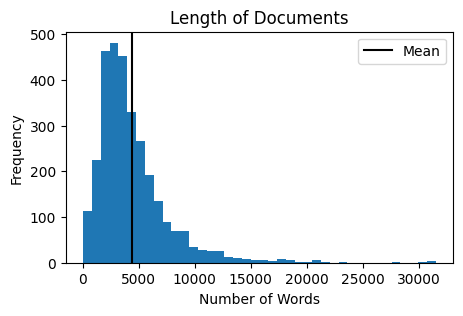

In [ ]:
plt.figure(figsize = (5,3))
plt.hist(disagreements['Length'], bins = 40)
plt.axvline(disagreements['Length'].mean(), color = 'black', label = 'Mean')
plt.title('Length of Documents')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Number of Words')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(disagreements['Words'], disagreements['ir_disagreement'], test_size=0.2, stratify = disagreements['ir_disagreement'])

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 4000

x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen)
x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen)

In [ ]:
embedding_dim = 500

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 4000, 500)         37252500  
                                                                 
 global_max_pooling1d_6 (Glo  (None, 500)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_6 (Flatten)         (None, 500)               0         
                                                                 
 dense_20 (Dense)            (None, 50)                25050     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 37,277,601
Trainable params: 37,277,601
Non-trainable params: 0
_________________________________________

In [ ]:
history = model.fit(x_train, y_train,
                     epochs=5,
                     verbose=True,
                     validation_data=(x_test, y_test),
                     batch_size=10)

Epoch 1/5
246/246 [==============================] - 161s 655ms/step - loss: 0.4477 - accuracy: 0.8201 - val_loss: 0.6437 - val_accuracy: 0.6407
Epoch 2/5
246/246 [==============================] - 158s 643ms/step - loss: 0.2924 - accuracy: 0.9113 - val_loss: 0.7012 - val_accuracy: 0.6585
Epoch 3/5
246/246 [==============================] - 160s 653ms/step - loss: 0.1851 - accuracy: 0.9560 - val_loss: 0.7824 - val_accuracy: 0.6439
Epoch 4/5
246/246 [==============================] - 159s 646ms/step - loss: 0.1104 - accuracy: 0.9837 - val_loss: 0.8758 - val_accuracy: 0.6228
Epoch 5/5
246/246 [==============================] - 167s 678ms/step - loss: 0.0599 - accuracy: 0.9927 - val_loss: 0.9460 - val_accuracy: 0.6244


In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose = False)
print(f"Training Accuracy: {accuracy}")

loss, accuracy = model.evaluate(x_test, y_test, verbose = False)
print(f"Testing Accuracy: {accuracy}")

Training Accuracy: 0.9938949942588806
Testing Accuracy: 0.6243902444839478


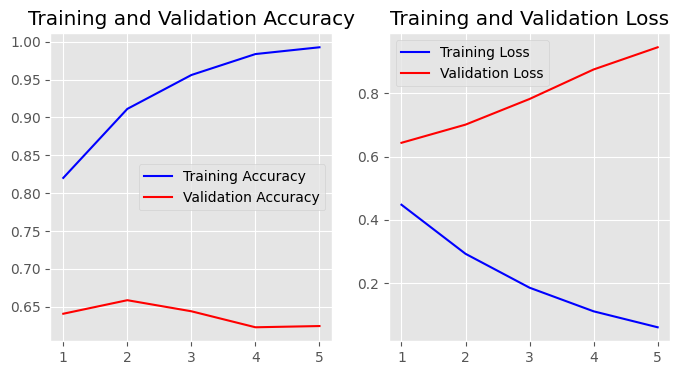

In [ ]:
plot_history(history)

# Different Class Weights

## Police Brutality

In [ ]:
pos_brut = pd.read_csv('/content/drive/MyDrive/Text Classification/Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_brut = pd.read_csv('/content/drive/MyDrive/Text Classification/Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
label = [1 for i in range(pos_brut.shape[0])] + [0 for i in range(neg_brut.shape[0])]
brut = pd.concat([pos_brut, neg_brut]).reset_index(drop = True)
brut['Label'] = label
brut.head()

,Words,Label
0,"united,state,court,appeal,ninth,circuit,public...",1
1,"united,state,court,appeal,eleventh,circuit,pub...",1
2,"united,state,court,appeal,ninth,circuit,public...",1
3,"flaum,circuit,judge,consolidated,appeal,two,ac...",1
4,"united,state,court,appeal,ninth,circuit,public...",1


In [ ]:
model_transf = SentenceTransformer('distilbert-base-nli-mean-tokens')
#model_transf = SentenceTransformer('all-mpnet-base-v2')
embeddings = model_transf.encode(brut['Words'], show_progress_bar=True)
brut_embeddings = embeddings.reshape(-1, len(embeddings[0]))

In [ ]:
brut['Length'] = brut.apply(lambda x: len(x['Words'].split(',')), axis = 1)
print(brut['Length'].mean())

1572.4040498442369


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(brut['Words'], brut['Label'], test_size=0.2, stratify = brut['Label'])

tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 1500

x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen)
x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen)

In [ ]:
embedding_dim = 500

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

weights = [0.6, 0.4]

model.compile(loss= 'binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'],
              loss_weights = weights)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1500, 500)         40216500  
                                                                 
 global_max_pooling1d_11 (G  (None, 500)               0         
 lobalMaxPooling1D)                                              
                                                                 
 flatten_11 (Flatten)        (None, 500)               0         
                                                                 
 dense_22 (Dense)            (None, 50)                25050     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 40241601 (153.51 MB)
Trainable params: 40241601 (153.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [ ]:
history = model.fit(x_train, y_train,
                     epochs=5,
                     verbose=True,
                     validation_data=(x_test, y_test),
                     batch_size=50)

Epoch 1/5
155/155 [==============================] - 249s 2s/step - loss: 0.2528 - accuracy: 0.8315 - val_loss: 0.0732 - val_accuracy: 0.9631
Epoch 2/5
155/155 [==============================] - 262s 2s/step - loss: 0.0503 - accuracy: 0.9694 - val_loss: 0.0569 - val_accuracy: 0.9647
Epoch 3/5
155/155 [==============================] - 247s 2s/step - loss: 0.0420 - accuracy: 0.9734 - val_loss: 0.0586 - val_accuracy: 0.9668
Epoch 4/5
155/155 [==============================] - 243s 2s/step - loss: 0.0362 - accuracy: 0.9773 - val_loss: 0.0546 - val_accuracy: 0.9663
Epoch 5/5
155/155 [==============================] - 238s 2s/step - loss: 0.0316 - accuracy: 0.9804 - val_loss: 0.0542 - val_accuracy: 0.9673


In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose = False)
print(f"Training Accuracy: {accuracy}")

loss, accuracy = model.evaluate(x_test, y_test, verbose = False)
print(f"Testing Accuracy: {accuracy}")

Training Accuracy: 0.9846832752227783
Testing Accuracy: 0.9672897458076477


In [ ]:
dfs_to_concat = [pd.Series(brut_embeddings[i]) for i in range(len(brut_embeddings))]
brut_transformed = pd.concat(dfs_to_concat, axis=1)
brut_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,9620,9621,9622,9623,9624,9625,9626,9627,9628,9629
0,-0.449610,-0.307212,-0.251342,-0.333406,-0.022377,-0.408548,-0.371217,-0.366268,-0.165827,-0.472012,...,-0.157738,-0.372888,-0.761004,-0.435219,-0.613193,-0.385718,-0.366868,-0.372228,-0.355286,-0.548488
1,-0.226631,-0.073482,-0.173191,-0.370657,-0.425499,-0.216541,-0.459870,-0.239774,-0.451687,-0.184429,...,-0.026737,-0.271948,-0.306868,0.124808,-0.248413,-0.165568,-0.068265,-0.192728,-0.277828,-0.206282
2,0.485383,0.494740,0.315124,0.352563,0.722203,0.340877,-0.019780,0.518429,0.582676,0.312961,...,0.088801,0.529514,0.475980,0.235834,0.567907,0.416580,0.057106,0.155506,0.460160,0.472462
3,0.084735,-0.133055,-0.074241,-0.139618,0.048689,-0.062722,0.074333,-0.090857,-0.134971,-0.537819,...,-0.074802,0.015356,-0.064202,-0.007999,0.069442,-0.118944,-0.121877,-0.474348,-0.110765,-0.216758
4,-0.912092,-0.690518,-0.539428,-0.804539,-0.637439,-0.643871,-0.586706,-0.692176,-0.329380,-0.366737,...,-0.847130,-0.709495,-0.967382,-0.693908,-0.761676,-0.685710,-0.820408,-0.952480,-0.686809,-0.577540


In [ ]:
#brut_transformed.to_csv('/content/drive/MyDrive/Text Classification/Brutality_Embeddings_Transformed.csv')

### Weights Comparison

In [ ]:
weights = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
x = brut['Words']
y = np.array(brut['Label'])
embedding_dim = 500

all_false_positives = []
all_false_negatives = []
all_false_positives_2 = []
all_false_negatives_2 = []
all_accuracies = []
all_all_preds = []

for i in tqdm(range(len(weights))):
  n = 7
  sample = brut.shape[0]//n
  accuracies = []
  false_positives = []
  false_negatives = []
  false_positives_2 = []
  false_negatives_2 = []
  all_preds = np.zeros(shape = len(y))
  all_indexes = np.arange(len(x))

  for j in tqdm(range(n)):
      test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
      train_indexes = [j for j in range(len(y)) if j not in test_indexes]
      x_train = x[train_indexes]
      x_test = x[test_indexes]

      y_train = y[train_indexes]
      y_test = y[test_indexes]

      tokenizer = Tokenizer(num_words=1500)
      tokenizer.fit_on_texts(x_train)
      x_train = tokenizer.texts_to_sequences(x_train)
      x_test = tokenizer.texts_to_sequences(x_test)
      vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
      maxlen = 1500
      x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen)
      x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen)

      model = Sequential()
      model.add(layers.Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=maxlen))
      model.add(layers.GlobalMaxPool1D())
      model.add(layers.Flatten())
      model.add(layers.Dense(50, activation='relu'))
      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss = 'binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'],
              loss_weights = [weights[i], 1 - weights[i]])

      model.fit(x_train, y_train,
                     epochs=2,
                     verbose=False,
                     batch_size=50)

      preds = model.predict(x_test).reshape(len(test_indexes))

      false_positive = len(preds[(preds >= 0.5) & (y_test == 0)])*100/sample
      false_negative = len(preds[(preds < 0.5) & (y_test == 1)])*100/sample
      false_2_positive = len(preds[(preds >= 0.5) & (y_test == 0)])*100/len(preds[preds >= 0.5])
      false_2_negative = len(preds[(preds < 0.5) & (y_test == 1)])*100/len(preds[preds < 0.5])
      binary_preds = np.array([1 if preds[i] >= 0.5 else 0 for i in range(len(preds))])
      correct = len(binary_preds[binary_preds == y_test])
      all_preds[test_indexes] = binary_preds

      all_indexes = list(all_indexes)
      for index in test_indexes:
          all_indexes.remove(index)
      all_indexes = np.array(all_indexes)

      accuracies.append(correct)
      false_positives.append(false_positive)
      false_negatives.append(false_negative)
      false_positives_2.append(false_2_positive)
      false_negatives_2.append(false_2_negative)

  all_false_positives.append(np.mean(false_positives))
  all_false_negatives.append(np.mean(false_negatives))
  all_false_positives_2.append(np.mean(false_positives_2))
  all_false_negatives_2.append(np.mean(false_negatives_2))
  all_accuracies.append(np.mean(accuracies))
  all_all_preds.append(all_preds)

  0%|          | 0/7 [00:00<?, ?it/s]

43/43 [==============================] - 3s 76ms/step



 14%|█▍        | 1/7 [08:13<49:21, 493.63s/it]

43/43 [==============================] - 5s 119ms/step



 29%|██▊       | 2/7 [17:06<43:02, 516.60s/it]

43/43 [==============================] - 4s 84ms/step



 43%|████▎     | 3/7 [25:08<33:23, 500.94s/it]

43/43 [==============================] - 3s 72ms/step



 57%|█████▋    | 4/7 [33:56<25:34, 511.43s/it]

43/43 [==============================] - 5s 117ms/step



 71%|███████▏  | 5/7 [42:45<17:16, 518.03s/it]

43/43 [==============================] - 4s 83ms/step



 86%|████████▌ | 6/7 [51:32<08:41, 521.10s/it]

43/43 [==============================] - 4s 84ms/step



  0%|          | 0/7 [00:00<?, ?it/s]

43/43 [==============================] - 3s 73ms/step



 14%|█▍        | 1/7 [08:45<52:33, 525.57s/it]

43/43 [==============================] - 3s 71ms/step



 29%|██▊       | 2/7 [16:32<40:56, 491.25s/it]

43/43 [==============================] - 5s 107ms/step



 43%|████▎     | 3/7 [24:26<32:12, 483.06s/it]

43/43 [==============================] - 4s 99ms/step



 57%|█████▋    | 4/7 [33:15<25:04, 501.53s/it]

43/43 [==============================] - 5s 115ms/step



 71%|███████▏  | 5/7 [42:09<17:05, 512.90s/it]

43/43 [==============================] - 4s 90ms/step



 86%|████████▌ | 6/7 [50:56<08:37, 517.94s/it]

43/43 [==============================] - 3s 71ms/step



  0%|          | 0/7 [00:00<?, ?it/s]

43/43 [==============================] - 3s 75ms/step



 14%|█▍        | 1/7 [07:45<46:35, 465.85s/it]

43/43 [==============================] - 3s 70ms/step



 29%|██▊       | 2/7 [16:31<41:45, 501.04s/it]

43/43 [==============================] - 3s 75ms/step



 43%|████▎     | 3/7 [25:18<34:11, 512.93s/it]

43/43 [==============================] - 3s 70ms/step



 57%|█████▋    | 4/7 [33:05<24:44, 494.83s/it]

43/43 [==============================] - 5s 107ms/step



 71%|███████▏  | 5/7 [41:56<16:55, 507.72s/it]

43/43 [==============================] - 5s 114ms/step



 86%|████████▌ | 6/7 [50:11<08:23, 503.34s/it]

43/43 [==============================] - 3s 74ms/step



  0%|          | 0/7 [00:00<?, ?it/s]

43/43 [==============================] - 5s 115ms/step



 14%|█▍        | 1/7 [08:48<52:50, 528.47s/it]

43/43 [==============================] - 3s 71ms/step



 29%|██▊       | 2/7 [16:35<41:00, 492.03s/it]

43/43 [==============================] - 5s 115ms/step



 43%|████▎     | 3/7 [24:22<32:04, 481.05s/it]

43/43 [==============================] - 4s 98ms/step



 57%|█████▋    | 4/7 [32:11<23:48, 476.09s/it]

43/43 [==============================] - 5s 113ms/step



 71%|███████▏  | 5/7 [39:59<15:46, 473.04s/it]

43/43 [==============================] - 3s 77ms/step



 86%|████████▌ | 6/7 [47:49<07:52, 472.19s/it]

43/43 [==============================] - 3s 75ms/step



  0%|          | 0/7 [00:00<?, ?it/s]

43/43 [==============================] - 3s 74ms/step



 14%|█▍        | 1/7 [08:48<52:52, 528.78s/it]

43/43 [==============================] - 5s 109ms/step



 29%|██▊       | 2/7 [17:45<44:28, 533.66s/it]

43/43 [==============================] - 3s 70ms/step



 43%|████▎     | 3/7 [25:32<33:31, 502.95s/it]

43/43 [==============================] - 5s 113ms/step



 57%|█████▋    | 4/7 [33:20<24:27, 489.24s/it]

43/43 [==============================] - 4s 86ms/step



 71%|███████▏  | 5/7 [41:07<16:02, 481.11s/it]

43/43 [==============================] - 3s 71ms/step



 86%|████████▌ | 6/7 [48:52<07:55, 475.71s/it]

43/43 [==============================] - 3s 72ms/step



  0%|          | 0/7 [00:00<?, ?it/s]

43/43 [==============================] - 4s 81ms/step



 14%|█▍        | 1/7 [08:47<52:43, 527.26s/it]

43/43 [==============================] - 4s 83ms/step



 29%|██▊       | 2/7 [17:39<44:09, 529.97s/it]

43/43 [==============================] - 3s 74ms/step



 43%|████▎     | 3/7 [26:32<35:25, 531.43s/it]

43/43 [==============================] - 3s 73ms/step



 57%|█████▋    | 4/7 [34:22<25:22, 507.40s/it]

43/43 [==============================] - 4s 86ms/step



 71%|███████▏  | 5/7 [41:57<16:16, 488.49s/it]

43/43 [==============================] - 3s 70ms/step



 86%|████████▌ | 6/7 [49:44<08:01, 481.12s/it]

43/43 [==============================] - 3s 69ms/step



100%|██████████| 6/6 [5:50:00<00:00, 3500.02s/it]


In [ ]:
print(all_false_positives)
print(all_false_negatives)
print(all_false_positives_2)
print(all_false_negatives_2)
print(all_accuracies)

[1.87012987012987, 1.4649350649350648, 1.6415584415584417, 1.4025974025974024, 1.4233766233766232, 1.5376623376623375]
[1.1740259740259742, 1.5896103896103895, 1.3298701298701299, 1.6103896103896105, 1.5584415584415585, 1.548051948051948]
[3.2668331210701846, 2.6004117929924675, 2.8786863315182893, 2.494519734847501, 2.5199923172376306, 2.715452138918645]
[2.7327991753460963, 3.6294513139817397, 3.0571953043151052, 3.6702076085486723, 3.566199830369152, 3.532425225899371]
[1333.142857142857, 1333.0, 1334.142857142857, 1333.5714285714287, 1334.0, 1332.5714285714287]


In [ ]:
dfs_to_concat = [pd.Series(all_all_preds[i]) for i in range(len(all_all_preds))]
preds_data = pd.concat(dfs_to_concat, axis=1)
preds_data.head()

,0,1,2,3,4,5
0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#preds_data.to_csv('/content/drive/MyDrive/Text Classification/NN_Weighted_Predictions.csv')

In [ ]:
nn_brut = pd.read_csv('/content/drive/MyDrive/Text Classification/NN_Weighted_Predictions.csv').drop('Unnamed: 0', axis = 1)
neg_brut = pd.read_csv('/content/drive/MyDrive/Text Classification/Neg_Cases.csv').drop('Unnamed: 0', axis = 1)
pos_brut = pd.read_csv('/content/drive/MyDrive/Text Classification/Pos_Cases.csv').drop('Unnamed: 0', axis = 1)
brut = pd.concat([pos_brut, neg_brut]).reset_index(drop = True)
brut = brut[['URL', 'Case Text', 'Labels']]
brut['NN Weighted Prediction'] = nn_brut['0']
brut['False Positive'] = 0
brut.loc[(brut['Labels'] == 0) & (brut['NN Weighted Prediction'] == 1), 'False Positive'] = 1
brut['False Negative'] = 0
brut.loc[(brut['Labels'] == 1) & (brut['NN Weighted Prediction'] == 0), 'False Negative'] = 1
#brut.to_csv('/content/drive/MyDrive/Text Classification/NN_Brutality_Weighted_Predictions_Full.csv')
brut.head()

,URL,Case Text,Labels,NN Weighted Prediction,False Positive,False Negative
0,https://www.leagle.com/decision/20061317464f3d...,"\n\n\nUnited States Court of Appeals, Ninth Ci...",1,1.0,0,0
1,https://www.leagle.com/decision/20051544423f3d...,"\n\n\nUnited States Court of Appeals, Ninth Ci...",1,1.0,0,0
2,https://www.leagle.com/decision/20051094418f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...",1,1.0,0,0
3,https://www.leagle.com/decision/2005507405f3d1...,"\n\n\nUnited States Court of Appeals, First Ci...",1,1.0,0,0
4,https://www.leagle.com/decision/20051470400f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...",1,1.0,0,0


## Immigration

### First Trial

In [ ]:
imm = pd.read_csv('/content/drive/MyDrive/Text Classification/Immigration_Predictions.csv').drop('Unnamed: 0', axis = 1)
label = imm['Label']
imm.head()

,URL,Case Text,Words,Label,Immigration ML Prediction,False Positive,False Negative
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0,0,0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0,0,0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0,0,0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,0.0,0,1
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0,0,0


In [ ]:
imm['Length'] = imm.apply(lambda x: len(x['Words'].split(',')), axis = 1)
print(imm['Length'].mean())

1156.2857074638268


In [ ]:
model_transf = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model_transf.encode(imm['Words'], show_progress_bar=True)
imm_embeddings = embeddings.reshape(-1, len(embeddings[0]))

Batches:   0%|          | 0/655 [00:00<?, ?it/s]

In [ ]:
dfs_to_concat = [pd.Series(imm_embeddings[i]) for i in range(len(imm_embeddings))]
imm_transformed = pd.concat(dfs_to_concat, axis=1)
imm_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,20931,20932,20933,20934,20935,20936,20937,20938,20939,20940
0,-0.492587,-0.321631,-0.656614,-0.830879,-0.661325,-0.199259,-0.402715,-0.772627,-0.443668,-0.269218,...,-0.157738,-0.372888,-0.761004,-0.435219,-0.613193,-0.385718,-0.366868,-0.372228,-0.355286,-0.548488
1,-0.448816,-0.471924,-0.269249,-0.198295,-0.425566,-0.291385,-0.265975,-0.259520,-0.345886,-0.366720,...,-0.026737,-0.271948,-0.306868,0.124808,-0.248413,-0.165568,-0.068265,-0.192728,-0.277828,-0.206282
2,0.697270,0.710941,0.297860,0.532796,0.480936,0.645908,0.268223,0.468645,0.550934,0.430017,...,0.088801,0.529514,0.475980,0.235834,0.567907,0.416580,0.057106,0.155506,0.460160,0.472462
3,-0.093110,-0.044742,0.121558,0.017442,0.045358,0.088291,0.005293,0.047420,0.200951,0.064708,...,-0.074802,0.015356,-0.064202,-0.007999,0.069442,-0.118944,-0.121877,-0.474348,-0.110765,-0.216758
4,-0.551024,-0.879048,-0.758447,-0.872885,-0.581585,-0.673105,-0.606649,-0.606927,-0.667862,-0.646816,...,-0.847130,-0.709495,-0.967382,-0.693908,-0.761676,-0.685710,-0.820408,-0.952480,-0.686809,-0.577540


In [ ]:
#imm_transformed.to_csv('/content/drive/MyDrive/Text Classification/Immortality_Embeddings_Transformed.csv')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imm['Words'], imm['Label'], test_size=0.2, stratify = imm['Label'])

tokenizer = Tokenizer(num_words=1200)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 1200

x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen)
x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen)

In [ ]:
embedding_dim = 500

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

weights = [0.6, 0.4]

model.compile(loss= 'binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'],
              loss_weights = weights)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 500)         68448500  
                                                                 
 global_max_pooling1d (Glob  (None, 500)               0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 50)                25050     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 68473601 (261.21 MB)
Trainable params: 68473601 (261.21 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
history = model.fit(x_train, y_train,
                     epochs=5,
                     verbose=True,
                     validation_data=(x_test, y_test),
                     batch_size=50)

Epoch 1/5
336/336 [==============================] - 712s 2s/step - loss: 0.0787 - accuracy: 0.9508 - val_loss: 0.0163 - val_accuracy: 0.9916
Epoch 2/5
336/336 [==============================] - 715s 2s/step - loss: 0.0124 - accuracy: 0.9941 - val_loss: 0.0126 - val_accuracy: 0.9938
Epoch 3/5
336/336 [==============================] - 699s 2s/step - loss: 0.0099 - accuracy: 0.9955 - val_loss: 0.0182 - val_accuracy: 0.9907
Epoch 4/5
336/336 [==============================] - 753s 2s/step - loss: 0.0082 - accuracy: 0.9955 - val_loss: 0.0123 - val_accuracy: 0.9943
Epoch 5/5
336/336 [==============================] - 665s 2s/step - loss: 0.0071 - accuracy: 0.9962 - val_loss: 0.0126 - val_accuracy: 0.9940


### Weights Comparison



In [ ]:
weights = [0.5,0.8,0.95]
x = imm['Words']
y = np.array(imm['Label'])
embedding_dim = 500

all_false_positives = []
all_false_negatives = []
all_false_positives_2 = []
all_false_negatives_2 = []
all_accuracies = []
all_all_preds = []

for i in tqdm(range(len(weights))):
  n = 3
  sample = imm.shape[0]//n
  accuracies = []
  false_positives = []
  false_negatives = []
  false_positives_2 = []
  false_negatives_2 = []
  all_preds = np.zeros(shape = len(y))
  all_indexes = np.arange(len(x))

  for j in tqdm(range(n)):
      test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
      train_indexes = [j for j in range(len(y)) if j not in test_indexes]
      x_train = x[train_indexes]
      x_test = x[test_indexes]

      y_train = y[train_indexes]
      y_test = y[test_indexes]

      tokenizer = Tokenizer(num_words=1200)
      tokenizer.fit_on_texts(x_train)
      x_train = tokenizer.texts_to_sequences(x_train)
      x_test = tokenizer.texts_to_sequences(x_test)
      vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
      maxlen = 1200
      x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen)
      x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen)

      model = Sequential()
      model.add(layers.Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=maxlen))
      model.add(layers.GlobalMaxPool1D())
      model.add(layers.Flatten())
      model.add(layers.Dense(50, activation='relu'))
      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss = 'binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'],
              loss_weights = [weights[i], 1 - weights[i]])

      model.fit(x_train, y_train,
                     epochs=2,
                     verbose=False,
                     batch_size=50)

      preds = model.predict(x_test).reshape(len(test_indexes))

      false_positive = len(preds[(preds >= 0.5) & (y_test == 0)])*100/sample
      false_negative = len(preds[(preds < 0.5) & (y_test == 1)])*100/sample
      false_2_positive = len(preds[(preds >= 0.5) & (y_test == 0)])*100/len(preds[preds >= 0.5])
      false_2_negative = len(preds[(preds < 0.5) & (y_test == 1)])*100/len(preds[preds < 0.5])
      binary_preds = np.array([1 if preds[i] >= 0.5 else 0 for i in range(len(preds))])
      correct = len(binary_preds[binary_preds == y_test])*100/sample
      all_preds[test_indexes] = binary_preds

      all_indexes = list(all_indexes)
      for index in test_indexes:
          all_indexes.remove(index)
      all_indexes = np.array(all_indexes)

      accuracies.append(correct)
      false_positives.append(false_positive)
      false_negatives.append(false_negative)
      false_positives_2.append(false_2_positive)
      false_negatives_2.append(false_2_negative)

  all_false_positives.append(np.mean(false_positives))
  all_false_negatives.append(np.mean(false_negatives))
  all_false_positives_2.append(np.mean(false_positives_2))
  all_false_negatives_2.append(np.mean(false_negatives_2))
  all_accuracies.append(np.mean(accuracies))
  all_all_preds.append(all_preds)

  0%|          | 0/3 [00:00<?, ?it/s]

219/219 [==============================] - 27s 122ms/step



 33%|███▎      | 1/3 [20:33<41:07, 1233.98s/it]

219/219 [==============================] - 29s 133ms/step



 67%|██████▋   | 2/3 [41:15<20:38, 1238.18s/it]

219/219 [==============================] - 16s 72ms/step



  0%|          | 0/3 [00:00<?, ?it/s]

219/219 [==============================] - 17s 78ms/step



 33%|███▎      | 1/3 [20:19<40:39, 1219.99s/it]

219/219 [==============================] - 16s 74ms/step



 67%|██████▋   | 2/3 [39:17<19:31, 1171.27s/it]

219/219 [==============================] - 21s 96ms/step



  0%|          | 0/3 [00:00<?, ?it/s]

219/219 [==============================] - 16s 75ms/step



 33%|███▎      | 1/3 [22:16<44:33, 1336.81s/it]

219/219 [==============================] - 17s 76ms/step



 67%|██████▋   | 2/3 [42:32<21:05, 1265.29s/it]

219/219 [==============================] - 17s 78ms/step



100%|██████████| 3/3 [3:04:21<00:00, 3687.16s/it]


In [ ]:
print(all_false_positives)
print(all_false_negatives)
print(all_false_positives_2)
print(all_false_negatives_2)
print(all_accuracies)

[0.3915950334288443, 0.2292263610315186, 0.3247373447946514]
[0.2148997134670487, 0.48233046800382046, 0.25310410697230185]
[0.8146035962330321, 0.4826534518007383, 0.6789433082381086]
[0.411523684298771, 0.917714618992993, 0.4850937938896243]
[99.3935052531041, 99.28844317096467, 99.42215854823304]


In [ ]:
dfs_to_concat = [pd.Series(all_all_preds[i]) for i in range(len(all_all_preds))]
preds_data = pd.concat(dfs_to_concat, axis=1)
preds_data.head()

,0,1,2
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [ ]:
#preds_data.to_csv('/content/drive/MyDrive/Text Classification/NN_Immigration_Weighted_Predictions.csv')

In [ ]:
nn_imm = pd.read_csv('/content/drive/MyDrive/Text Classification/NN_Immigration_Weighted_Predictions.csv').drop('Unnamed: 0', axis = 1)
imm = pd.read_csv('/content/drive/MyDrive/Text Classification/Immigration_Predictions.csv').drop('Unnamed: 0', axis = 1)
imm = imm[['URL', 'Case Text', 'Words', 'Label']]
imm['NN Weighted Prediction'] = nn_imm['0']
imm['False Positive'] = 0
imm.loc[(imm['Label'] == 0) & (imm['NN Weighted Prediction'] == 1), 'False Positive'] = 1
imm['False Negative'] = 0
imm.loc[(imm['Label'] == 1) & (imm['NN Weighted Prediction'] == 0), 'False Negative'] = 1
#imm.to_csv('/content/drive/MyDrive/Text Classification/NN_Immigration_Weighted_Predictions_Full.csv')
imm.head()

,URL,Case Text,Words,Label,NN Weighted Prediction,False Positive,False Negative
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0,0,0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0,0,0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0,0,0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,1.0,0,0
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0,0,0


## Civil Rights